Name: Smita Gupta<br>
USC ID: 4123927261

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.cluster import SpectralClustering
from matplotlib.pyplot import cm
import random
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

1. Supervised, Semi-Supervised, and Unsupervised Learning<br>
(a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+ %28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/ machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes. Use the first 20% of the positive and negative classes in the file as the test set and the rest as the training set.

In [2]:
#Setting the paths
wdbc_file = "Homework 6 Data/wdbc.data"
banknote_file = "Homework 6 Data/data_banknote_authentication.csv"
M = 30

In [3]:
#Reading the data
def load_data(file_path, X_startIndex=2, X_endIndex=None, y_index=1):
    row_data = pd.read_csv(file_path, encoding="utf-8", header=None)
    if X_endIndex == None:
        X_endIndex = row_data.shape[1]
    X = row_data.iloc[:, X_startIndex:X_endIndex]
    y = row_data.iloc[:, y_index]
    return X.to_numpy(), y.to_numpy()

In [5]:
#Splitting the data
def train_test_split(X, y, test_size=0.2, random_state=None, 
                                        pos_class='B', neg_class='M'):
    if random_state:
        np.random.seed(random_state)
        shuffled_indexes = np.random.permutation(len(X))
        X = X[shuffled_indexes]
        y = y[shuffled_indexes]

    positiveClassAmount = len(X[y == pos_class])
    negativeClassAmount = len(X[y == neg_class])
    positivetestSetLength = round(positiveClassAmount * test_size)
    negativetestSetLength = round(negativeClassAmount * test_size)

    X_test_B = X[y == pos_class][:positivetestSetLength]
    X_test_M = X[y == neg_class][:negativetestSetLength]
    X_test = np.concatenate((X_test_B, X_test_M), axis=0)

    X_train_B = X[y == pos_class][positivetestSetLength:]
    X_train_M = X[y == neg_class][negativetestSetLength:]
    X_train = np.concatenate((X_train_B, X_train_M), axis=0)

    y_test_B = y[y == pos_class][:positivetestSetLength]
    y_test_M = y[y == neg_class][:negativetestSetLength]
    y_test = np.concatenate((y_test_B, y_test_M), axis=0)

    y_train_B = y[y == pos_class][positivetestSetLength:]
    y_train_M = y[y == neg_class][negativetestSetLength:]
    y_train = np.concatenate((y_train_B, y_train_M), axis=0)

    return X_train, X_test, y_train, y_test

In [6]:
#Loading the data from WDBC file
X_data, y_data = load_data(wdbc_file)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.2,
                                                    random_state=2333)
X_data = MinMaxScaler().fit(X_data).transform(X_data)
labelEncoder = LabelEncoder().fit(['B', 'M'])
y_data = labelEncoder.transform(y_data)

print("the shape of X_data is: ", X_data.shape)
print("the shape of y_data is: ", y_data.shape)
print("the shape of X_train is: ", X_train.shape)
print("the shape of X_test is: ", X_test.shape)
print("the shape of y_train is: ", y_train.shape)
print("the shape of y_test is: ", y_test.shape)

the shape of X_data is:  (569, 30)
the shape of y_data is:  (569,)
the shape of X_train is:  (456, 30)
the shape of X_test is:  (113, 30)
the shape of y_train is:  (456,)
the shape of y_test is:  (113,)


1) b) Monte-Carlo Simulation: Repeat the following procedures for supervised, un- supervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and nega- tive classes as the test set). Then compare the average scores (accuracy, precision, recall, F-score, and AUC) that you obtain from each algorithm.<br>
i. Supervised Learning: Train an L1-penalized SVM to classify the data.
Use 5 fold cross validation to choose the penalty parameter. Use normalized
data. Report the average accuracy, precision, recall, F-score, and AUC, for
both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [7]:
#Plotting ROC & AUC curve
def plot_roc_auc(y_true, y_predict, title="ROC"):
    falsePositiveRate, truePositiveRate, thresholds = roc_curve(y_true, y_predict)
    area = auc(falsePositiveRate, truePositiveRate)
    plt.plot(falsePositiveRate, truePositiveRate, color='red', label='AUC = ' + str(area))
    plt.plot([0, 1], [0, 1], linestyle='dotted')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
#Declaring dictionaries and lists for further usage
y_trainList = dict()
y_testList = dict()
y_train_predictList = dict()
y_test_predictList = dict()

trainAccuracyList = list()
trainPrecisionList = list()
trainRecallRateList = list()
trainF_scoreList = list()
trainAUCList = list()

testAccuracyList = list()
testPrecisionList = list()
testRecallRateList = list()
testF_scoreList = list()
testAUCList = list()
trainCrosstabList = dict()
testCrosstabList = dict()

In [9]:
warnings.filterwarnings("ignore")
parameters = {"C": np.linspace(1, 8, 10)}

for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                        random_state=i, pos_class=0, 
                                                        neg_class=1)
    y_trainList[i] = y_train
    y_testList[i] = y_test

    linSVC = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(linSVC, parameters, cv=5, n_jobs=-1)
    gridCV.fit(X_train, y_train)

    bestClf = gridCV.best_estimator_
    y_train_predict = bestClf.predict(X_train)
    y_test_predict = bestClf.predict(X_test)

    y_train_predictList[i] = y_train_predict
    y_test_predictList[i] = y_test_predict

    trainCrosstab = pd.crosstab(y_train, y_train_predict, rownames=['True'], 
                                colnames=['Predicted'], margins=True)
    trainCrosstabList[i] = trainCrosstab
    testCrosstab = pd.crosstab(y_test, y_test_predict, rownames=['True'], 
                               colnames=['Predicted'], margins=True)
    testCrosstabList[i] = testCrosstab

    trainPrecision, trainRecall, trainF_score, _ = score(y_train, y_train_predict, 
                                                         average='binary', pos_label=0)
    trainPrecisionList.append(trainPrecision)
    trainRecallRateList.append(trainRecall)
    trainF_scoreList.append(trainF_score)

    testPrecision, testRecall, testF_score, _ = score(y_test, y_test_predict, 
                                                      average='binary', pos_label=0)
    testPrecisionList.append(testPrecision)
    testRecallRateList.append(testRecall)
    testF_scoreList.append(testF_score)

    falsePositiveRate, truePositiveRate, _ = roc_curve(y_train, y_train_predict)
    trainAUC = auc(falsePositiveRate, truePositiveRate)
    trainAUCList.append(trainAUC)

    falsePositiveRate, truePositiveRate, _ = roc_curve(y_test, y_test_predict)
    testAUC = auc(falsePositiveRate, truePositiveRate)
    testAUCList.append(testAUC)

    trainAccuracyList.append(accuracy_score(y_train, y_train_predict))
    testAccuracyList.append(accuracy_score(y_test, y_test_predict))

100%|██████████| 30/30 [01:47<00:00,  3.60s/it]


In [10]:
#Calculating confusion matrix for training dataset
index_best_prec = np.argmax(trainPrecisionList)
print("Training Confusion Matrix:\n")
print(trainCrosstabList[index_best_prec])

Training Confusion Matrix:

Predicted    0    1  All
True                    
0          286    0  286
1            1  169  170
All        287  169  456


In [11]:
#Printing training average information
print("Training Average Information:\n")
print("Average Recall Rate: ", np.average(trainRecallRateList))
print("Average Precision: ", np.average(trainPrecisionList))
print("Average Accuracy Score: ", np.average(trainAccuracyList))
print("Average AUC: ", np.average(trainAUCList))
print("Average F1 -Score: ", np.average(trainF_scoreList))

Training Average Information:

Average Recall Rate:  0.9945221445221446
Average Precision:  0.9835432855813617
Average Accuracy Score:  0.986111111111111
Average AUC:  0.983241464417935
Average F1 -Score:  0.9889936837684761


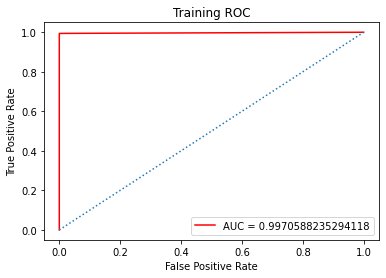

In [12]:
supTrainDF = pd.DataFrame(data={'Algorithm': ['Supervised Train']})
supTrainDF['AVG Accuracy'] = np.average(trainPrecisionList)
supTrainDF['AVG Precision'] = np.average(trainPrecisionList)
supTrainDF['AVG Recall'] = np.average(trainRecallRateList)
supTrainDF['AVG F Score'] = np.average(trainF_scoreList)
supTrainDF['AVG AUC'] = np.average(trainAUCList)
infoDF = pd.DataFrame().append(supTrainDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_trainList[index_best_prec], 
         y_train_predictList[index_best_prec], title="Training ROC")

In [13]:
#Calculating confusion matrix for testing dataset
index_best_prec = np.argmax(testPrecisionList)
print("Testing Confusion Matrix:\n")
print(testCrosstabList[index_best_prec])

Testing Confusion Matrix:

Predicted   0   1  All
True                  
0          68   3   71
1           0  42   42
All        68  45  113


In [14]:
#Calculating confusion matrix for testing dataset
print("Testing Average Information:\n")
print("Average Recall Rate: ", np.average(testRecallRateList))
print("Average Precision: ", np.average(testPrecisionList))
print("Average AUC: ", np.average(testAUCList))
print("Average Accuracy Score: ", np.average(testAccuracyList))
print("Average F1 -Score: ", np.average(testF_scoreList))

Testing Average Information:

Average Recall Rate:  0.9835680751173709
Average Precision:  0.965834172575868
Average AUC:  0.9620221327967806
Average Accuracy Score:  0.9675516224188789
Average F1 -Score:  0.9744106639101641


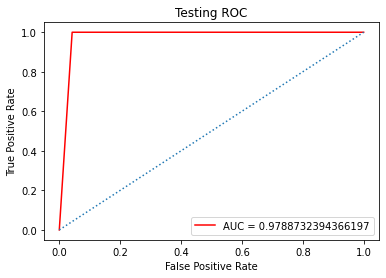

In [15]:
supTestDF = pd.DataFrame(data={'Algorithm': ['Supervised Test']})
supTestDF['AVG Accuracy'] = np.average(testAccuracyList)
supTestDF['AVG Precision'] = np.average(testPrecisionList)
supTestDF['AVG Recall'] = np.average(testRecallRateList)
supTestDF['AVG F Score'] = np.average(testF_scoreList)
supTestDF['AVG AUC'] = np.average(testAUCList)

infoDF = infoDF.append(supTestDF)

#Plotting ROC & AUC Curve for testing dataset
plot_roc_auc(y_testList[index_best_prec], 
         y_test_predictList[index_best_prec], title="Testing ROC")

1) b) ii) Semi-Supervised Learning/ Self-training: select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.<br>
A. Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                    random_state=2333, pos_class=0, 
                                                    neg_class=1)

labeled_X, unlabeled_X, labeled_y, expert = train_test_split(X_train, y_train, test_size=0.5,
                                                             random_state=666, pos_class=0,
                                                             neg_class=1)

parameters = {"C": np.linspace(0.01, 2, 10)}

gridCV = GridSearchCV(LinearSVC(penalty="l1", dual=False, max_iter=10000), 
                      parameters, cv=5, n_jobs=-1)
gridCV.fit(labeled_X, labeled_y)

print("The test score is:", gridCV.score(X_test, y_test))
print("The best penalty parameter C is:", gridCV.best_params_)

The test score is: 0.9734513274336283
The best penalty parameter C is: {'C': 1.557777777777778}


1) b) ii) B. Find the unlabeled datapoint that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data and the average accuracy, precision, recall, F-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [17]:
#Declaring dictionaries and lists for further usage
y_trainList = dict()
y_testList = dict()
y_train_predictList = dict()
y_test_predictList = dict()
y_train_trueList = dict()

trainAccuracyList = list()
trainPrecisionList = list()
trainRecallRateList = list()
trainF_scoreList = list()
trainAUCList = list()

trainCrosstabList = dict()
testCrosstabList = dict()

testAccuracyList = list()
testPrecisionList = list()
testRecallRateList = list()
testF_scoreList = list()
testAUCList = list()

In [18]:
#Fitting Semi-learning model
def semi_learning_mod(X_train, y_train, X_test, clf):
    X_test_shape = X_test.shape[0]
    for _ in range(X_test_shape):
        absDist = np.absolute(bestClf.decision_function(X_test))
        indexOfMaxDist = np.argmax(absDist)
        farthestDataPoint = np.array(X_test[indexOfMaxDist]).reshape(1, 30)
        predictedResult = clf.predict(farthestDataPoint)

        X_test = np.delete(X_test, indexOfMaxDist, axis=0)
        X_train = np.append(X_train, farthestDataPoint, axis=0)
        y_train = np.append(y_train, predictedResult, axis=0)

        clf.fit(X_train, y_train)

    return clf

In [19]:
warnings.filterwarnings("ignore")
parameters = {"C": np.linspace(1, 5, 10)}
for i in tqdm(range(M)):
    labeled_X, unlabeled_X, labeled_y, expert = train_test_split(X_train, y_train, test_size=0.5,
                                                                 random_state=i, pos_class=0,
                                                                 neg_class=1)
    gridCV = GridSearchCV(LinearSVC(penalty="l1", dual=False, max_iter=5000), 
                          parameters, cv=5, n_jobs=-1)
    gridCV.fit(labeled_X, labeled_y)
    bestClf = gridCV.best_estimator_

    bestClf = semi_learning_mod(labeled_X.copy(), labeled_y.copy(), 
                                unlabeled_X.copy(), bestClf)

    y_train_predict = bestClf.predict(labeled_X)
    y_test_predict = bestClf.predict(X_test)

    y_train_predictList[i] = y_train_predict
    y_test_predictList[i] = y_test_predict
    y_train_trueList[i] = labeled_y

    trainCrosstab = pd.crosstab(labeled_y, y_train_predict, rownames=['True'], 
                                colnames=['Predicted'], margins=True)
    
    trainCrosstabList[i] = trainCrosstab
    
    testCrosstab = pd.crosstab(y_test, y_test_predict, rownames=['True'], 
                               colnames=['Predicted'], margins=True)
    testCrosstabList[i] = testCrosstab

    trainAccuracyList.append(accuracy_score(labeled_y, y_train_predict))
    testAccuracyList.append(accuracy_score(y_test, y_test_predict))

    trainPrecision, trainRecall, trainF_score, _ = score(labeled_y, y_train_predict, 
                                                         average='binary', pos_label=0)
    trainPrecisionList.append(trainPrecision)
    trainRecallRateList.append(trainRecall)
    trainF_scoreList.append(trainF_score)

    testPrecision, testRecall, testF_score, _ = score(y_test, y_test_predict, 
                                                      average='binary', pos_label=0)
    testPrecisionList.append(testPrecision)
    testRecallRateList.append(testRecall)
    testF_scoreList.append(testF_score)

    falsePositiveRate, truePositiveRate, _ = roc_curve(labeled_y, y_train_predict)
    trainAUC = auc(falsePositiveRate, truePositiveRate)
    trainAUCList.append(trainAUC)

    falsePositiveRate, truePositiveRate, _ = roc_curve(y_test, y_test_predict)
    testAUC = auc(falsePositiveRate, truePositiveRate)
    testAUCList.append(testAUC)

100%|██████████| 30/30 [04:35<00:00,  9.17s/it]


In [20]:
#Calculating confusion matrix for training dataset
index_best_prec = np.argmax(trainPrecisionList)
print("Training Confusion Matrix\n")
print(trainCrosstabList[index_best_prec])

Training Confusion Matrix

Predicted    0   1  All
True                   
0          142   1  143
1            0  85   85
All        142  86  228


In [21]:
#Calculating average information for training dataset
print("Training Average Information:\n")
print("Average AUC: ", np.average(trainAUCList))
print("Average Accuracy Score: ", np.average(trainAccuracyList))
print("Average Recall Rate: ", np.average(trainRecallRateList))
print("Average Precision: ", np.average(trainPrecisionList))
print("Average F1 -Score: ", np.average(trainF_scoreList))

Training Average Information:

Average AUC:  0.9796242972713561
Average Accuracy Score:  0.9839181286549706
Average Recall Rate:  0.9965034965034965
Average Precision:  0.9783464932248588
Average F1 -Score:  0.987317888453483


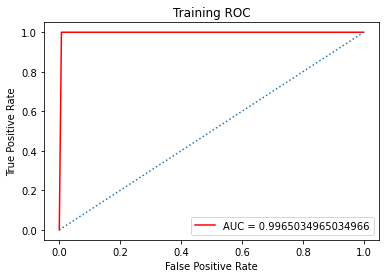

In [22]:
semiTrainDF = pd.DataFrame(data={'Algorithm': ['Semi-Supervised Train']})
semiTrainDF['AVG Accuracy'] = np.average(trainAccuracyList)
semiTrainDF['AVG Precision'] = np.average(trainPrecisionList)
semiTrainDF['AVG Recall'] = np.average(trainRecallRateList)
semiTrainDF['AVG F Score'] = np.average(trainF_scoreList)
semiTrainDF['AVG AUC'] = np.average(trainAUCList)

infoDF = infoDF.append(semiTrainDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_train_trueList[index_best_prec], 
         y_train_predictList[index_best_prec], title="Training ROC")

In [23]:
#Calculating confusion matrix for training dataset
index_best_prec = np.argmax(testPrecisionList)
print("Testing Confusion Matrix:\n")
print(testCrosstabList[index_best_prec])

Testing Confusion Matrix:

Predicted   0   1  All
True                  
0          69   2   71
1           0  42   42
All        69  44  113


In [24]:
#Calculating average information for training dataset
print("Testing Average Information:\n")
print("Average AUC: ", np.average(testAUCList))
print("Average Accuracy Score: ", np.average(testAccuracyList))
print("Average Recall Rate: ", np.average(testRecallRateList))
print("Average Precision: ", np.average(testPrecisionList))
print("Average F1 -Score: ", np.average(testF_scoreList))

Testing Average Information:

Average AUC:  0.9699977643639615
Average Accuracy Score:  0.9749262536873159
Average Recall Rate:  0.9892018779342725
Average Precision:  0.9717476477336825
Average F1 -Score:  0.9802810103365789


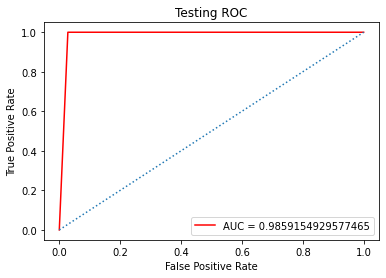

In [25]:
semiTestDF = pd.DataFrame(data={'Algorithm': ['Semi-Supervised Test']})
semiTestDF['AVG Accuracy'] = np.average(testAccuracyList)
semiTestDF['AVG Precision'] = np.average(testPrecisionList)
semiTestDF['AVG Recall'] = np.average(testRecallRateList)
semiTestDF['AVG F Score'] = np.average(testF_scoreList)
semiTestDF['AVG AUC'] = np.average(testAUCList)

infoDF = infoDF.append(semiTestDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_test, y_test_predictList[index_best_prec], title="Testing ROC")

1) b) iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.<br>
A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?

In [26]:
#Declaring lists for further usage
precisionList = list()
recallRateList = list()
f_scoreList = list()
accuracyList = list()
aucList = list()

In [27]:
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                        random_state=i, pos_class=0, 
                                                        neg_class=1)
    k_means_clf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_labels = k_means_clf.fit_predict(X_train)
    precision, recall, f_score, _ = score(y_train, cluster_labels, 
                                          average='binary', pos_label=0)
    precisionList.append(precision)
    recallRateList.append(recall)
    f_scoreList.append(f_score)
    accuracyList.append(accuracy_score(y_train, cluster_labels))
    falsePositiveRate, truePositiveRate, _ = roc_curve(y_train, cluster_labels)
    aucList.append(auc(falsePositiveRate, truePositiveRate))

100%|██████████| 30/30 [00:01<00:00, 22.27it/s]


In [28]:
print("Maximum Accuracy Score: ", max(accuracyList))
print("Maximum Precision: ", max(precisionList))
print("Maximum Recall Rate: ", max(recallRateList))
print("Maximum F1 -Score: ", max(f_scoreList))
print("Maximum AUC: ", max(aucList))

Maximum Accuracy Score:  0.9407894736842105
Maximum Precision:  0.93
Maximum Recall Rate:  0.993006993006993
Maximum F1 -Score:  0.9544688026981449
Maximum AUC:  0.9259975318798848


We can avoid to get local minimum by setting the random seed and also trying to run algorithm multiple times.<br> <br>
1) b) iii) B. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the
labels provided by k-means with the true labels of the training data and
report the average accuracy, precision, recall, F-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

In [29]:
#Declaring lists for further usage
precisionList = list()
recallRateList = list()
f_scoreList = list()
aucList = list()
accuracyList = list()
y_predict = None
y_true = None

In [30]:
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                         random_state=i, pos_class=0,
                                                         neg_class=1)
    
    k_means_clf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_labels = k_means_clf.fit_predict(X_train)
    indexOfPosDist = np.argsort(cdist(X_train, k_means_clf.cluster_centers_, 
                                      'euclidean')[:, 0], axis=0)[:30]
    indexOfNegDist = np.argsort(cdist(X_train, k_means_clf.cluster_centers_, 
                                      'euclidean')[:, 1], axis=0)[:30]

    y_train_pos_nearest_30 = y_train[indexOfPosDist]
    y_train_neg_nearest_30 = y_train[indexOfNegDist]
    pos_label = Counter(y_train_pos_nearest_30).most_common(1)[0][0]
    neg_label = Counter(y_train_neg_nearest_30).most_common(1)[0][0]
    
    majorityPolling = np.vectorize(lambda x: pos_label if x == 0 else neg_label)
    new_cluster_labels = majorityPolling(cluster_labels)
    y_predict = new_cluster_labels
    y_true = y_train
    precision, recall, f_score, _ = score(y_train, y_predict, average='binary', pos_label=0)
    accuracyList.append(accuracy_score(y_train, y_predict))
    precisionList.append(precision)
    recallRateList.append(recall)
    f_scoreList.append(f_score)
    falsePositiveRate, truePositiveRate, _ = roc_curve(y_train, y_predict)
    aucList.append(auc(falsePositiveRate, truePositiveRate))

100%|██████████| 30/30 [00:01<00:00, 19.43it/s]


In [31]:
print("Overall Average Information:\n")
print("Average AUC: ", np.average(aucList))
print("Average Accuracy Score: ", np.average(accuracyList))
print("Average Recall Rate: ", np.average(recallRateList))
print("Average Precision: ", np.average(precisionList))
print("Average F1 -Score: ", np.average(f_scoreList))

Overall Average Information:

Average AUC:  0.9115617715617716
Average Accuracy Score:  0.9280701754385968
Average Recall Rate:  0.9764568764568767
Average Precision:  0.9146853554716695
Average F1 -Score:  0.944525055616172


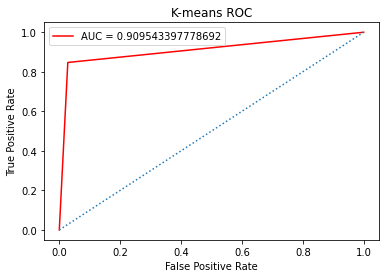

In [32]:
unSupTrainDF = pd.DataFrame(data={'Algorithm': ['UnSupervised Train']})
unSupTrainDF['AVG Accuracy'] = np.average(accuracyList)
unSupTrainDF['AVG Precision'] = np.average(precisionList)
unSupTrainDF['AVG Recall'] = np.average(recallRateList)
unSupTrainDF['AVG F Score'] = np.average(f_scoreList)
unSupTrainDF['AVG AUC'] = np.average(aucList)

infoDF = infoDF.append(unSupTrainDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_true, y_predict, title="K-means ROC")

In [33]:
#Calculating Confusion Matrix
print("Confusion Matrix about One Run:\n")
print(pd.crosstab(y_true, y_predict, rownames=['True'], colnames=['Predicted'], margins=True))

Confusion Matrix about One Run:

Predicted    0    1  All
True                    
0          278    8  286
1           26  144  170
All        304  152  456


1) b) iii) C.
Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

In [34]:
#Declaring lists for further usage
precisionList = list()
recallRateList = list()
f_scoreList = list()
aucList = list()
y_test_predict = list()
accuracyList = list()
y_test_true = None

In [35]:
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                        random_state=i, pos_class=0,
                                                        neg_class=1)

    k_means_clf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_labels = k_means_clf.fit_predict(X_test)
    posDist = cdist(X_test, k_means_clf.cluster_centers_, 'euclidean')[:, 0]
    negDist = cdist(X_test, k_means_clf.cluster_centers_, 'euclidean')[:, 1]
    y_test_predict.clear()
    for index, pred_label in enumerate(cluster_labels):
        if pred_label == 0:
            y_test_predict.append(0 if abs(posDist[index]) < abs(negDist[index]) else 1)
        else:
            y_test_predict.append(1 if abs(posDist[index]) > abs(negDist[index]) else 0)

    majorityPredClass = Counter(y_test_predict).most_common(1)[0][0]
    if majorityPredClass != 0:
        flip = np.vectorize(lambda x: 1 if x == 0 else 0)
        y_test_predict = flip(y_test_predict).tolist()
    
    y_test_true = y_test
    precision, recall, f_score, _ = score(y_test, y_test_predict, average='binary', pos_label=0)
    precisionList.append(precision)
    recallRateList.append(recall)
    f_scoreList.append(f_score)
    falsePositiveRate, truePositiveRate, _ = roc_curve(y_test, y_test_predict)
    aucList.append(auc(falsePositiveRate, truePositiveRate))
    accuracyList.append(accuracy_score(y_test, y_test_predict))

100%|██████████| 30/30 [00:00<00:00, 36.67it/s]


In [36]:
#Calculating Confusion Matrix
print("Confusion Matrix about One Run:\n")
print(pd.crosstab(y_test_true, np.reshape(y_test_predict, (-1,)), 
                  rownames=['True'], colnames=['Predicted'], margins=True))

Confusion Matrix about One Run:

Predicted   0   1  All
True                  
0          70   1   71
1           6  36   42
All        76  37  113


In [37]:
print("Overall Average Information:\n")
print("Average AUC: ", np.average(aucList))
print("Average Accuracy Score: ", np.average(accuracyList))
print("Average Recall Rate: ", np.average(recallRateList))
print("Average Precision: ", np.average(precisionList))
print("Average F1 -Score: ", np.average(f_scoreList))

Overall Average Information:

Average AUC:  0.9091828750279453
Average Accuracy Score:  0.924778761061947
Average Recall Rate:  0.9699530516431925
Average Precision:  0.9163324961320425
Average F1 -Score:  0.941946901188207


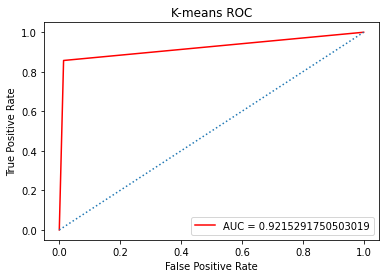

In [38]:
unSupTestDF = pd.DataFrame(data={'Algorithm': ['UnSupervised Test']})
unSupTestDF['AVG Accuracy'] = np.average(accuracyList)
unSupTestDF['AVG Precision'] = np.average(precisionList)
unSupTestDF['AVG Recall'] = np.average(recallRateList)
unSupTestDF['AVG F Score'] = np.average(f_scoreList)
unSupTestDF['AVG AUC'] = np.average(aucList)
infoDF = infoDF.append(unSupTestDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_test_true, y_test_predict, title="K-means ROC")

1.) b) iv)
Spectral Clustering: Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.<br> <br> 
Run the Spectral Clustering algorithm multiple times. Make sure that you initialize the algoritm randomly

In [39]:
#Declaring lists for further usage
precisionList = list()
recallRateList = list()
f_scoreList = list()
accuracyList = list()
aucList = list()

In [40]:
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                        random_state=i, pos_class=0, 
                                                        neg_class=1)
    
    spectral_clf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_labels = spectral_clf.fit_predict(X_train)
    accuracyList.append(accuracy_score(y_train, cluster_labels))
    precision, recall, f_score, _ = score(y_train, cluster_labels, 
                                          average='binary', pos_label=0)
    precisionList.append(precision)
    recallRateList.append(recall)
    f_scoreList.append(f_score)
    falsePositiveRate, truePositiveRate, _ = roc_curve(y_train, cluster_labels)
    aucList.append(auc(falsePositiveRate, truePositiveRate))

100%|██████████| 30/30 [00:02<00:00, 10.47it/s]


In [41]:
print("Maximum AUC: ", max(aucList))
print("Maximum Accuracy Score: ", max(accuracyList))
print("Maximum F1 -Score: ", max(f_scoreList))
print("Maximum Precision: ", max(precisionList))
print("Maximum Recall Rate: ", max(recallRateList))

Maximum AUC:  0.8535787741670096
Maximum Accuracy Score:  0.8881578947368421
Maximum F1 -Score:  0.9173419773095625
Maximum Precision:  0.8549848942598187
Maximum Recall Rate:  1.0


The majority poll becomes the label predicted by Spectral Clustering for the members of each cluster. Then compare the labels provided by Spectral Clustering with the true labels of the training data and report the average accuracy, precision, recall, F-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.

In [42]:
#Declaring lists for further usage
accuracyList = list()
precisionList = list()
recallRateList = list()
f_scoreList = list()
aucList = list()
y_train_predict = None
y_train_true = None

In [43]:
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                        random_state=i, pos_class=0,
                                                        neg_class=1)

    spectral_clf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_labels = spectral_clf.fit_predict(X_train)

    indexOfPosDist = np.argwhere(cluster_labels == 0).reshape(-1, )
    indexOfNegDist = np.argwhere(cluster_labels == 1).reshape(-1, )

    y_train_pos = y_train[indexOfPosDist]
    y_train_neg = y_train[indexOfNegDist]
    pos_label = Counter(y_train_pos).most_common(1)[0][0]
    neg_label = Counter(y_train_neg).most_common(1)[0][0]
    cluster_labels[indexOfPosDist] = pos_label
    cluster_labels[indexOfNegDist] = neg_label

    y_train_predict = cluster_labels
    y_train_true = y_train
    precision, recall, f_score, _ = score(y_train_true, y_train_predict, 
                                          average='binary', pos_label=0)
    precisionList.append(precision)
    recallRateList.append(recall)
    f_scoreList.append(f_score)
    falsePositiveRate, truePositiveRate, _ = roc_curve(y_train_true, y_train_predict)
    aucList.append(auc(falsePositiveRate, truePositiveRate))
    accuracyList.append(accuracy_score(y_train_true, y_train_predict))

100%|██████████| 30/30 [00:02<00:00, 14.54it/s]


In [44]:
print("Overall Average Information:\n")
print("Average AUC: ", np.average(aucList))
print("Average Accuracy Score: ", np.average(accuracyList))
print("Average Recall Rate: ", np.average(recallRateList))
print("Average Precision: ", np.average(precisionList))
print("Average F1 -Score: ", np.average(f_scoreList))

Overall Average Information:

Average AUC:  0.8150143973673385
Average Accuracy Score:  0.8602339181286549
Average Recall Rate:  0.9927738927738929
Average Precision:  0.8219839460200201
Average F1 -Score:  0.8992203321950625


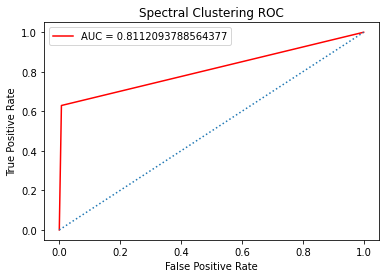

In [45]:
spectralTrainDF = pd.DataFrame(data={'Algorithm': ['Spectral Clustering Train']})
spectralTrainDF['AVG Accuracy'] = np.average(accuracyList)
spectralTrainDF['AVG Precision'] = np.average(precisionList)
spectralTrainDF['AVG Recall'] = np.average(recallRateList)
spectralTrainDF['AVG F Score'] = np.average(f_scoreList)
spectralTrainDF['AVG AUC'] = np.average(aucList)
infoDF = infoDF.append(spectralTrainDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_train_true, y_train_predict, title="Spectral Clustering ROC")

In [46]:
#Calculating Confusion Matrix
print("Confusion Matrix about One Run:\n")
print(pd.crosstab(y_train_true, y_train_predict, 
                  rownames=['True'], colnames=['Predicted'], margins=True))

Confusion Matrix about One Run:

Predicted    0    1  All
True                    
0          284    2  286
1           63  107  170
All        347  109  456


Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.

In [47]:
#Declaring lists for further usage
accuracyList = list()
precisionList = list()
recallRateList = list()
f_scoreList = list()
aucList = list()
y_test_predict = None
y_test_true = None

In [48]:
for i in tqdm(range(M)):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                        random_state=i, pos_class=0,
                                                        neg_class=1)
    
    spectral_clf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_labels = spectral_clf.fit_predict(X_test)

    indexOfPosDist = np.argwhere(cluster_labels == 0).reshape(-1, )
    indexOfNegDist = np.argwhere(cluster_labels == 1).reshape(-1, )

    y_test_pos = y_test[indexOfPosDist]
    y_test_neg = y_test[indexOfNegDist]
    pos_label = Counter(y_test_pos).most_common(1)[0][0]
    neg_label = Counter(y_test_neg).most_common(1)[0][0]
    cluster_labels[indexOfPosDist] = pos_label
    cluster_labels[indexOfNegDist] = neg_label

    y_test_predict = cluster_labels
    y_test_true = y_test
    precision, recall, f_score, _ = score(y_test_true, y_test_predict, 
                                          average='binary', pos_label=0)
    precisionList.append(precision)
    recallRateList.append(recall)
    f_scoreList.append(f_score)
    falsePositiveRate, truePositiveRate, _ = roc_curve(y_test_true, y_test_predict)
    aucList.append(auc(falsePositiveRate, truePositiveRate))
    accuracyList.append(accuracy_score(y_test_true, y_test_predict))

100%|██████████| 30/30 [00:01<00:00, 24.20it/s]


In [49]:
print("Overall Average Information:\n")
print("AVG AUC: ", np.average(aucList))
print("AVG Accuracy Score: ", np.average(accuracyList))
print("AVG Recall Rate: ", np.average(recallRateList))
print("AVG Precision: ", np.average(precisionList))
print("AVG F1 -Score: ", np.average(f_scoreList))

Overall Average Information:

AVG AUC:  0.8015817124972056
AVG Accuracy Score:  0.8498525073746312
AVG Recall Rate:  0.9896713615023477
AVG Precision:  0.8179073425956712
AVG F1 -Score:  0.8940048081424009


In [50]:
#Calculating Confusion Matrix
print("Confusion Matrix about One Run:\n")
print(pd.crosstab(y_test_true, y_test_predict, 
                  rownames=['True'], colnames=['Predicted'], margins=True))

Confusion Matrix about One Run:

Predicted   0   1  All
True                  
0          70   1   71
1          15  27   42
All        85  28  113


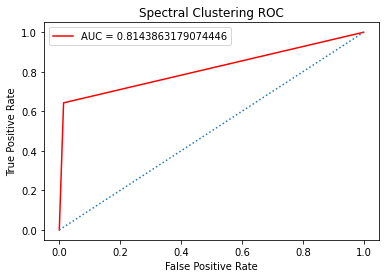

In [51]:
spectralTestDF = pd.DataFrame(data={'Algorithm': ['Spectral Clustering Test']})
spectralTestDF['AVG Accuracy'] = np.average(accuracyList)
spectralTestDF['AVG Precision'] = np.average(precisionList)
spectralTestDF['AVG Recall'] = np.average(recallRateList)
spectralTestDF['AVG F Score'] = np.average(f_scoreList)
spectralTestDF['AVG AUC'] = np.average(aucList)
infoDF = infoDF.append(spectralTestDF)

#Plotting ROC & AUC Curve
plot_roc_auc(y_test_true, y_test_predict, title="Spectral Clustering ROC")

1) b) v) One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

In [52]:
infoDF

,Algorithm,AVG Accuracy,AVG Precision,AVG Recall,AVG F Score,AVG AUC
0,Supervised Train,0.983543,0.983543,0.994522,0.988994,0.983241
0,Supervised Test,0.967552,0.965834,0.983568,0.974411,0.962022
0,Semi-Supervised Train,0.983918,0.978346,0.996503,0.987318,0.979624
0,Semi-Supervised Test,0.974926,0.971748,0.989202,0.980281,0.969998
0,UnSupervised Train,0.928070,0.914685,0.976457,0.944525,0.911562
0,UnSupervised Test,0.924779,0.916332,0.969953,0.941947,0.909183
0,Spectral Clustering Train,0.860234,0.821984,0.992774,0.899220,0.815014
0,Spectral Clustering Test,0.849853,0.817907,0.989671,0.894005,0.801582


Sol) We cannot just rely on a high accuracy score to determine how good our model is doing in the case of binary classification problem, especially when we have a skewed data set. The data is not skewed in this problem, thus, average precision and avg recall rate could be more reliable evaluation criterion, which describe how many patients our algorithm predicts correctly and in all of the patients who have breast cancer, how many people are predicted correctly.<br>
From infoDF it can be seen that supervised learning performed really good on this issue. but the semi-supervised learning made a great prediction as well. They both have pretty similar avg precision and recall scores. It should be good to say that they have a tie kind of situation .<br>
As for the Unsupervised learning algorithm model, it has a high recall score but a relatively low precision, implying that this algorithm tends to predict most people have breast cancer.
About Spectral learning, the precision and recall score is way lower than other algorithms. Maybe this model is not a good choice for this issue.

2. Active Learning Using Support Vector Machines<br>
(a) Download the banknote authentication Data Set from: https://archive.ics. uci.edu/ml/datasets/banknote+authentication. Choose 472 data points ran- domly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [53]:
def train_test_split_by_no(X, y, test_size=472, random_state=None):
    if random_state:
        np.random.seed(random_state)

    shuffled_indexes = np.random.permutation(len(X))

    test_indexes = shuffled_indexes[:test_size]
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes]
    y_train = y[train_indexes]

    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

In [54]:
X_data, y_data = load_data(banknote_file, X_startIndex=0, 
                           X_endIndex=4, y_index=-1)
X_train, X_test, y_train, y_test = train_test_split_by_no(X_data, y_data, 
                                                          test_size=472,
                                                          random_state=2333)


print("The shape of X_data is: ", X_data.shape)
print("The shape of y_data is: ", y_data.shape)
print("\nThe shape of X_train is: ", X_train.shape)
print("The shape of X_test is: ", X_test.shape)
print("The shape of y_train is: ", y_train.shape)
print("The shape of y_test is: ", y_test.shape)

The shape of X_data is:  (1372, 4)
The shape of y_data is:  (1372,)

The shape of X_train is:  (900, 4)
The shape of X_test is:  (472, 4)
The shape of y_train is:  (900,)
The shape of y_test is:  (472,)


2) (b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.<br>
i. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [55]:
def check_y(data):
    return True if len(Counter(data).keys()) == 2 else False

In [56]:
def linearStdSVC():
    return Pipeline([
        ("svc", LinearSVC(penalty="l1", dual=False, max_iter=5000))
    ])

def plot_multiple(x_data, Y_data, title="Multiple Plots"):
    plt.figure(figsize=(12, 4))
    length = len(Y_data)
    color = iter(cm.rainbow(np.linspace(0, 1, length)))
    for i in range(length):
        plt.plot(x_data, Y_data[i], marker='', color=next(color), linewidth=1, alpha=0.3)

    plt.xlabel('The Size Of Training Instance')
    plt.ylabel('Test Error')
    plt.ylim([0, 0.05])
    plt.title(title)
    plt.show()

In [57]:
passiveOverallErrorList = list()

X_data = StandardScaler().fit(X_data).transform(X_data)
parameters = {"svc__C": np.linspace(1, 5, 10)}

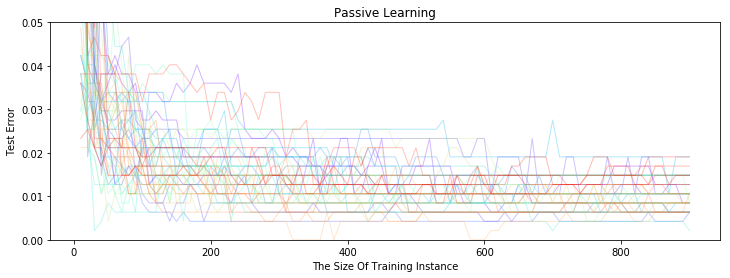

In [21]:
warnings.filterwarnings("ignore")

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split_by_no(X_data, y_data, 
                                                              test_size=472, random_state=i)
    indexListLength = len(X_train)
    indexList = np.arange(0, indexListLength)
    X_train_pool = np.array([[]])
    y_train_pool = np.array([])
    tempErrorList = list()
    for __ in range(90):
        indexes = random.sample(indexList.tolist(), 10)
        while not check_y(y_train[indexes]):
            indexes = random.sample(indexList.tolist(), 10)
        indexList = np.setdiff1d(indexList, np.array(indexes))
        X_train_pool = np.append(X_train_pool, X_train[indexes]).reshape(-1, 4)
        y_train_pool = np.append(y_train_pool, y_train[indexes]).reshape(-1, )
        ls_scv = linearStdSVC()
        cv = 10 if len(y_train_pool) > 10 else 5
        gridCV = GridSearchCV(ls_scv, parameters, cv=cv, n_jobs=-1, scoring='accuracy')
        gridCV.fit(X_train_pool, y_train_pool)
        tempErrorList.append(1 - gridCV.score(X_test, y_test))

    passiveOverallErrorList.append(tempErrorList)
    
#Plotting multiple plots
plot_multiple(np.arange(10, 901, 10).tolist(), 
               passiveOverallErrorList, title="Passive Learning")

2) b) ii) Train a SVM with a pool of 10 randomly selected datapoints from the training set 5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

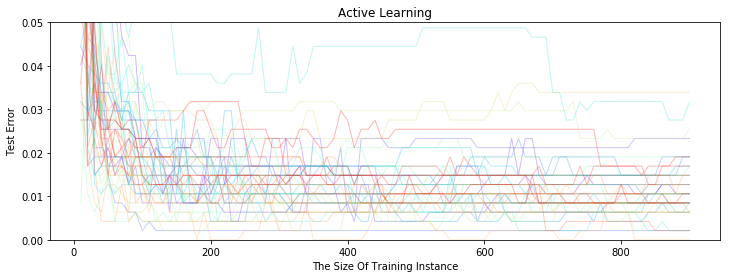

In [23]:
activeOverallErrorList = list()

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split_by_no(X_data, y_data, 
                                                              test_size=472, random_state=i)
    indexListLength = len(X_train)
    indexList = np.arange(0, indexListLength)
    X_train_pool = np.array([[]])
    y_train_pool = np.array([])
    tempErrorList = list()

    ##If all selected data points are from one class, select another set of 10 data points randomly
    indexes = random.sample(indexList.tolist(), 10)
    while not check_y(y_train[indexes]):
        indexes = random.sample(indexList.tolist(), 10)
    indexList = np.setdiff1d(indexList, np.array(indexes))

    X_train_pool = np.append(X_train_pool, X_train[indexes]).reshape(-1, 4)
    y_train_pool = np.append(y_train_pool, y_train[indexes]).reshape(-1, )
    y_train_pool = y_train_pool.astype('int32')
    
    ls_scv = linearStdSVC()
    gridCV = GridSearchCV(ls_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
    gridCV.fit(X_train_pool, y_train_pool)
    tempErrorList.append(1 - gridCV.score(X_test, y_test))

    for __ in range(89):
        remainingData = X_train[indexList]
        distances = gridCV.best_estimator_.decision_function(remainingData).reshape(-1, 1)
        remainingData = np.hstack((remainingData, abs(distances)))
        closetIndexes = remainingData[:, 4].argsort()[:10]
        firstCloset10XPoints = X_train[closetIndexes]
        firstCloset10YPoints = y_train[closetIndexes]
        indexList = np.setdiff1d(indexList, np.array(closetIndexes))
        X_train_pool = np.append(X_train_pool, firstCloset10XPoints).reshape(-1, 4)
        y_train_pool = np.append(y_train_pool, firstCloset10YPoints).reshape(-1, )

        ls_scv = linearStdSVC()
        gridCV = GridSearchCV(ls_scv, parameters, cv=10, n_jobs=-1, scoring='accuracy')
        gridCV.fit(X_train_pool, y_train_pool)
        tempErrorList.append(1 - gridCV.score(X_test, y_test))

    activeOverallErrorList.append(tempErrorList)
    
#Plotting multiple plots
plot_multiple(np.arange(10, 901, 10).tolist(), 
               activeOverallErrorList, title="Active Learning")

2) (c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

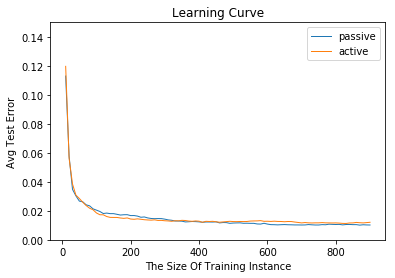

In [24]:
avgPassiveErrorList = np.average(np.array(passiveOverallErrorList), axis=0)
avgActiveErrorList = np.average(np.array(activeOverallErrorList), axis=0)
plt.plot(np.arange(10, 901, 10), avgPassiveErrorList, marker='', linewidth=1, label="passive")
plt.plot(np.arange(10, 901, 10), avgActiveErrorList, marker='', linewidth=1, label="active")
plt.xlabel('The Size Of Training Instance')
plt.ylabel('Avg Test Error')
plt.ylim([0, 0.15])
plt.title("Learning Curve")
plt.legend()
plt.show()

Sol) In this issue, both passive and active learning methods, the average test error drops rapidly from the beginning and become level off at some point as the number of training instances increases. And also the slope of active learning is smoother than passive learning. Before I plot this figure, I expected that active learning has a lower test error since we named the algorithm is an "active" learner, it should and need to provide us a lower test error. But actually the truth is the passive learning is better in this issue. I also read some articles about this issue to explain this. From Article "Efficient Active Learning" (http://www.cs.cornell.edu/~nk/pubs/exp2al.pdf), the authors think the active learning would have a measurable improvement (a lower test error) over the passive learner when we work on a multi-class problem. But in the binary classification issue, they make not much difference.